In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#configs
max_tokens = 20000
max_length = 1200
vocab_size_train = max_tokens
embedding_dim = 256

developing = False

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [2]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_from_comp = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [4]:
train, test = train_test_split(train_data_raw, test_size=0.2, random_state=21) #20% for test
train, val = train_test_split(train, test_size=0.1, random_state=21) # 10% for validation
train

targets=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

train_targets = train[targets]
val_targets = val[targets]
test_targets = test[targets]

train_targets_ds = tf.convert_to_tensor(train_targets)
val_targets_ds = tf.convert_to_tensor(val_targets)
test_targets_ds = tf.convert_to_tensor(test_targets)

train_text_only = tf.convert_to_tensor(train['full_text'])
val_text_only = tf.convert_to_tensor(val['full_text'])
test_text_only = tf.convert_to_tensor(test['full_text'])

## for submission 
all_train_targets = train_data_raw[targets]
all_train_targets_ds = tf.convert_to_tensor(all_train_targets)
all_train_text_only = tf.convert_to_tensor(train_data_raw['full_text'])

all_test_text_only = tf.convert_to_tensor(test_from_comp['full_text'])


2022-12-04 00:35:29.502414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:35:29.503641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:35:29.504585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:35:29.505578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 00:35:29.506503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [5]:
# text_vectorization = layers.TextVectorization(
#     max_tokens=max_tokens,
#     output_mode="multi_hot"
# )

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

#use the dataset to index the dataset vocab via the adapt method
text_vectorization.adapt(train_text_only)

train_features_ds = text_vectorization(train_text_only)
val_features_ds = text_vectorization(val_text_only)
test_features_ds = text_vectorization(test_text_only)

#for submission
all_train_features_ds = text_vectorization(all_train_text_only)
all_test_features_ds = text_vectorization(all_test_text_only)


2022-12-04 00:35:32.567921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [6]:
def get_model(max_tokens=max_tokens, hidden_dim=32):
    
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    embeddings = layers.Embedding(vocab_size_train, embedding_dim, name="embedding")(inputs)

    conv_x =  layers.Conv1D( filters=64*2, kernel_size=3, padding='same', activation='relu')(embeddings)
    conv_x =  layers.Dropout(rate=0.5)(conv_x)
    max_pooling_x = layers.MaxPooling1D()(conv_x)
    
    
    conv_x =  layers.Conv1D( filters=64, kernel_size=3, padding='same', activation='relu')(embeddings)
    conv_x =  layers.Dropout(rate=0.5)(conv_x)
    max_pooling_x = layers.MaxPooling1D()(conv_x)

    conv_x =  layers.Conv1D( filters=32, kernel_size=4, padding='same', activation='relu')(conv_x)
    conv_x =  layers.Dropout(rate=0.5)(conv_x)
    max_pooling_x = layers.MaxPooling1D()(conv_x)

    conv_x =  layers.Conv1D( filters=16, kernel_size=5, padding='same', activation='relu')(conv_x)
    conv_x =  layers.Dropout(rate=0.5)(conv_x)
    #max_pooling_x = layers.MaxPooling1D()(conv_x)

    #max_pooling_x = layers.MaxPooling1D()(conv_x)

    average_pooling_x = layers.GlobalAveragePooling1D()(max_pooling_x)

    #flattener = layers.Flatten()(average_pooling_x)

    dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
    dense_x =  layers.Dropout(rate=0.2)(dense_x)

    dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
    dense_x =  layers.Dropout(rate=0.2)(dense_x)

    dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
    dense_x =  layers.Dropout(rate=0.2)(dense_x)

    dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
    dense_x =  layers.Dropout(rate=0.2)(dense_x)
    
    

    outputs = layers.Dense(6, activation=None)(dense_x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="mean_absolute_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )]
    )
    return model


#train model and test
model = get_model()
model.summary()

if developing:

    callbacks = [
        keras.callbacks.ModelCheckpoint("model_one_hot_bidir_lstm.keras", save_best_only=True)
    ]
    hist = model.fit(
        x=train_features_ds,
        y=train_targets_ds,
        validation_data = (
            val_features_ds, val_targets_ds
        ),
        epochs=100,
        callbacks=callbacks,
        batch_size=32
    )

    model = keras.models.load_model("model_one_hot_bidir_lstm.keras")
    print(f"Test acc: {model.evaluate(test_features_ds, test_targets_ds, 1)}")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         5120000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          49216     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          8224      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0     

2022-12-04 00:35:36.117203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


88/88 [==============================] - 9s 16ms/step - loss: 1.8608 - root_mean_squared_error: 2.2764 - val_loss: 1.6788 - val_root_mean_squared_error: 1.8684
Epoch 2/100
88/88 [==============================] - 1s 13ms/step - loss: 1.1405 - root_mean_squared_error: 1.5667 - val_loss: 1.4489 - val_root_mean_squared_error: 1.5798
Epoch 3/100
88/88 [==============================] - 1s 13ms/step - loss: 0.9518 - root_mean_squared_error: 1.3634 - val_loss: 1.3853 - val_root_mean_squared_error: 1.5113
Epoch 4/100
88/88 [==============================] - 1s 12ms/step - loss: 0.8853 - root_mean_squared_error: 1.2625 - val_loss: 1.1859 - val_root_mean_squared_error: 1.3250
Epoch 5/100
88/88 [==============================] - 1s 12ms/step - loss: 0.8544 - root_mean_squared_error: 1.2037 - val_loss: 1.2240 - val_root_mean_squared_error: 1.3572
Epoch 6/100
88/88 [==============================] - 1s 12ms/step - loss: 0.7926 - root_mean_squared_error: 1.1091 - val_loss: 1.2146 - val_root_mean_sq

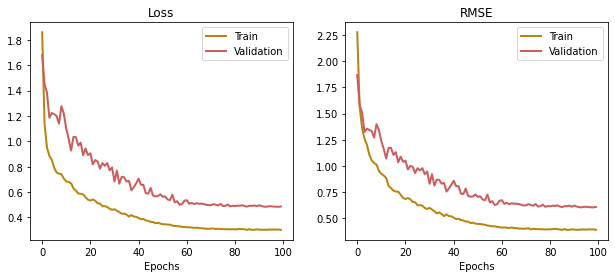

In [8]:
if developing:
    # grab history
    history = hist.history

    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)

    plt.plot(history['loss'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('Loss');

    ax = fig.add_subplot(1, 3, 2)

    plt.plot(history['root_mean_squared_error'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_root_mean_squared_error'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('RMSE');


In [9]:
#
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embedding_w_cnn.keras", save_best_only=True)
]
hist = model.fit(
    x=all_train_features_ds,
    y=all_train_targets_ds,
    validation_data = None,
    epochs=100,
    callbacks=callbacks,
    batch_size=32
)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         5120000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          49216     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          8224      
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0   

## Submission to contest

In [10]:
test_predictions = model.predict(all_test_features_ds)
test_predictions = pd.DataFrame(test_predictions)

test_from_comp['cohesion'] = test_predictions[0]
test_from_comp['syntax'] = test_predictions[1]
test_from_comp['vocabulary'] = test_predictions[2]
test_from_comp['phraseology'] = test_predictions[3]
test_from_comp['grammar'] = test_predictions[4]
test_from_comp['conventions'] = test_predictions[5]
test_from_comp

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,2.763386,2.624248,2.976989,2.758628,2.476336,2.640294
1,000BAD50D026,Do you think students would benefit from being...,3.160357,3.064666,3.047583,3.008413,3.211820,3.198819
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",2.860122,2.891871,3.111457,3.032906,3.048331,2.907004


In [11]:
res = test_from_comp.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)